# Imports

In [57]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime
# Maybe use https://gitlab.com/mike01/pypacker or https://stackoverflow.com/questions/30826123/python-scapy-vs-dpkt
import scapy
import pickle
import subprocess
from subprocess import PIPE
from pathlib import Path
from datetime import datetime, timedelta
from scapy.all import *
import networkx as nx
import sharedVariables
from sharedVariables import *

In [58]:
# Datasets
dataset_sources = {
    'baseline': 'data\\20210910-baseline',
    'syncmesh': 'data\\20210910-syncmesh-gzip',
}


In [59]:
# Utility Functions
def to_human_readable(size):
    power = 1000
    n = 0
    mem = {0 : 'B', 1: 'KB', 2: 'MB', 3: 'GB', 4: 'TB'}
    while size > power:
        size /=  power
        n += 1
    return "{0:.2f} {1}".format(size, mem[n])

In [60]:
def filterDataForSeperator(df): 
    df = df[df["ip.src"].isin([ip_seperator, ip_client])]
    df = df[df["ip.dst"].isin([ip_seperator, ip_client])]
    df = df[df["tcp.dstport"] == 443]
    return df

def filterDataForLocalTraffic(df): 
    df = df[df["ip.src"].str.contains(r'^10\.')]
    df = df[df["ip.dst"].str.contains(r'^10\.')]
    return df

def loadDataSet(folder):
    df_base = None
    for filename in os.listdir(folder):
        if filename.endswith(".csv"):
            csvfile = os.path.join(Path.cwd(), folder, filename)
            # print(csvfile)
            EPOCH = datetime(1900, 1, 1)
            currentdf = pd.read_csv(csvfile)

            currentdf["frame.time_epoch"] = currentdf["frame.time_epoch"].apply(lambda x: datetime.utcfromtimestamp(float(x)))

            currentdf.set_index('frame.time_epoch', inplace=True)

            currentdf.dropna(inplace=True)
            # currentdf = currentdf[currentdf["src"].str.contains(r'^10\.')]
            # currentdf = currentdf[currentdf["dst"].str.contains(r'^10\.')]
            
            # currentdf = currentdf[currentdf["sport"] != "ssh"]
            # currentdf = currentdf[currentdf["dport"] != "ssh"]
            if (df_base is None):
                df_base = currentdf
            else:
                df_base = df_base.append(currentdf)

        else:
            continue

    seperatordf = filterDataForSeperator(df_base)
    timings = seperatordf.index.values
    df_base = filterDataForLocalTraffic(df_base)
    return (df_base, timings)

datasets = {}
for source in dataset_sources:
    datasets[source] = loadDataSet(dataset_sources[source])
    
datasets["baseline"]

(                                 ip.id     ip.src     ip.dst  ip.len  \
 frame.time_epoch                                                       
 2021-09-10 14:12:49.058527  0x0000ca30  10.1.0.11   10.1.0.3    60.0   
 2021-09-10 14:12:49.058756  0x00002627  10.1.0.11   10.1.0.3    60.0   
 2021-09-10 14:12:49.060365  0x00000000   10.1.0.3  10.1.0.11    60.0   
 2021-09-10 14:12:49.060365  0x00000000   10.1.0.3  10.1.0.11    60.0   
 2021-09-10 14:12:49.060401  0x0000ca31  10.1.0.11   10.1.0.3    52.0   
 ...                                ...        ...        ...     ...   
 2021-09-10 14:37:36.288381  0x00006137   10.1.0.3  10.3.0.13    52.0   
 2021-09-10 14:37:36.288417  0x00000000  10.3.0.13   10.1.0.3    40.0   
 2021-09-10 14:37:36.288425  0x00000000  10.3.0.13   10.1.0.3    40.0   
 2021-09-10 14:37:36.288428  0x00009bf2   10.1.0.3  10.3.0.13    52.0   
 2021-09-10 14:37:36.288436  0x0000538a  10.3.0.13   10.1.0.3    52.0   
 
                             tcp.srcport  tcp.dst

In [61]:
def calcSubset(df):
    nodes = list(dict.fromkeys(df["ip.src"].unique().tolist() + df["ip.dst"].unique().tolist()))

    betweenNodesDataset = {}
    nodeCombinations = list(itertools.combinations(nodes, r=2))
    for combination in nodeCombinations: 
        # print(combination)
        # Use both src_ip and dest_ip as they are not request related
        betweenNodesDataset["between " + combination[0] + " and " + combination[1]] = df[df['ip.src'].isin(combination) & df['ip.dst'].isin(combination)]

    return betweenNodesDataset

node_datasets = {}
for key in datasets:
    node_datasets[key] = calcSubset(datasets[key][0])

setname = "baseline"
for key in node_datasets[setname]:
    print(key, ":", len(node_datasets[setname][key]))

between 10.1.0.11 and 10.1.0.3 : 4610
between 10.1.0.11 and 10.1.0.2 : 0
between 10.1.0.11 and 10.2.0.12 : 0
between 10.1.0.11 and 10.3.0.13 : 0
between 10.1.0.3 and 10.1.0.2 : 24914
between 10.1.0.3 and 10.2.0.12 : 11305
between 10.1.0.3 and 10.3.0.13 : 10704
between 10.1.0.2 and 10.2.0.12 : 0
between 10.1.0.2 and 10.3.0.13 : 0
between 10.2.0.12 and 10.3.0.13 : 0


In [62]:
# Experiments
def splitExperiments(df, timings):
    experiments = ["collect1", "collect7", "collect14", "collect30", "aggregate1", "aggregate7", "aggregate14", "aggregate30"]
    return_data = {}
    for index, experiment in enumerate(experiments): 
        return_data[experiment] = calcSubset(df.loc[str(timings[index]):str(timings[index + 1])])
    return return_data

node_experiment_datasets = {}
for key in datasets:
    node_experiment_datasets[key] = splitExperiments(datasets[key][0], datasets[key][1])

setname = "baseline"
for key in node_experiment_datasets[setname]:
    print(key, ":", len(node_experiment_datasets[setname][key]))


C:\Users\danie\AppData\Local\Temp/ipykernel_7016/4140361115.py:6: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  return_data[experiment] = calcSubset(df.loc[str(timings[index]):str(timings[index + 1])])


collect1 : 10
collect7 : 10
collect14 : 10
collect30 : 10
aggregate1 : 10
aggregate7 : 10
aggregate14 : 10
aggregate30 : 10


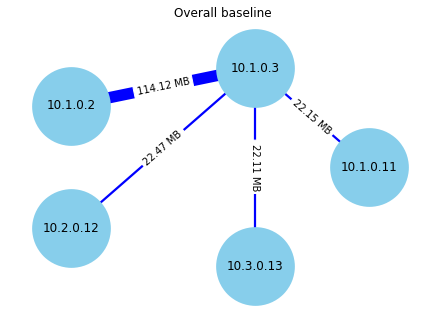

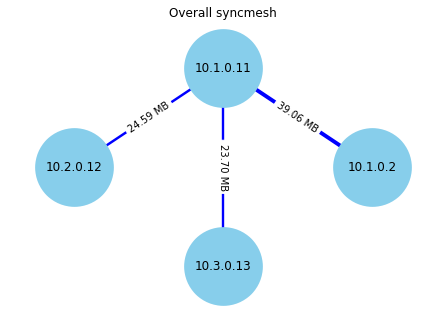

In [63]:

for index, subset_key in enumerate(node_datasets):
    G = nx.Graph()
    # print(subset_key)
    for node_dataset_key in node_datasets[subset_key]: 
        subset = node_datasets[subset_key][node_dataset_key]
        # print(node_dataset_key) 
        if len(subset["ip.dst"]) > 0:
            G.add_edge(subset["ip.src"].iloc[0], subset["ip.dst"].iloc[0], color='b', weight=subset["ip.len"].sum()/10000000, label=to_human_readable(subset["ip.len"].sum()))

    pos = nx.circular_layout(G)

    plt.figure(index+1)
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight'] for u,v in edges]
    edgelabels = dict([((u, v), G[u][v]['label']) for u,v in edges])
    nx.draw(G, pos, edge_color=colors, width=weights, with_labels = True, node_size=1500, node_color="skyblue", node_shape="o", alpha=1, linewidths=40)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edgelabels)

    plt.axis('off')
    axis = plt.gca()
    axis.set_title("Overall " + subset_key)
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    
plt.show()

In [71]:
node_experiment_datasets["syncmesh"]["aggregate30"]['between 10.2.0.12 and 10.1.0.11'].to_csv("test.csv")
node_experiment_datasets["baseline"]["aggregate30"]['between 10.1.0.3 and 10.1.0.2'].to_csv("test2.csv")

{'baseline': {'collect1': {'between 10.1.0.11 and 10.1.0.3':                                  ip.id     ip.src     ip.dst  ip.len  \
   frame.time_epoch                                                       
   2021-09-10 14:12:49.058527  0x0000ca30  10.1.0.11   10.1.0.3    60.0   
   2021-09-10 14:12:49.058756  0x00002627  10.1.0.11   10.1.0.3    60.0   
   2021-09-10 14:12:49.060365  0x00000000   10.1.0.3  10.1.0.11    60.0   
   2021-09-10 14:12:49.060365  0x00000000   10.1.0.3  10.1.0.11    60.0   
   2021-09-10 14:12:49.060401  0x0000ca31  10.1.0.11   10.1.0.3    52.0   
   ...                                ...        ...        ...     ...   
   2021-09-10 14:12:49.096989  0x000065ce   10.1.0.3  10.1.0.11    52.0   
   2021-09-10 14:12:49.097077  0x00000000  10.1.0.11   10.1.0.3    40.0   
   2021-09-10 14:12:49.097177  0x0000262c  10.1.0.11   10.1.0.3    52.0   
   2021-09-10 14:12:49.097205  0x0000d69f   10.1.0.3  10.1.0.11    52.0   
   2021-09-10 14:12:49.097362  0x00008e3c 

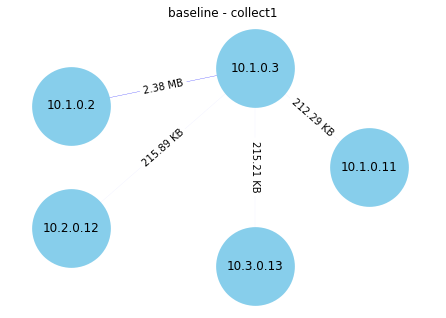

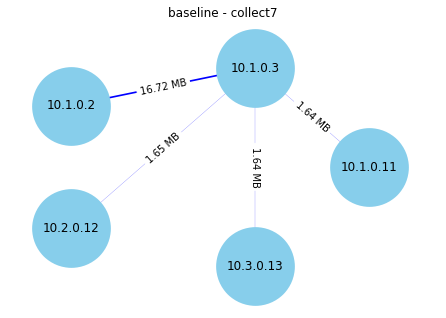

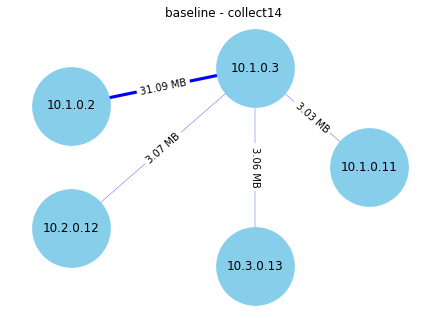

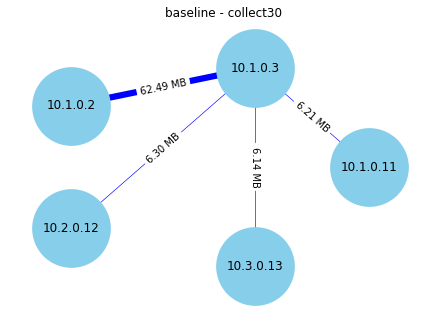

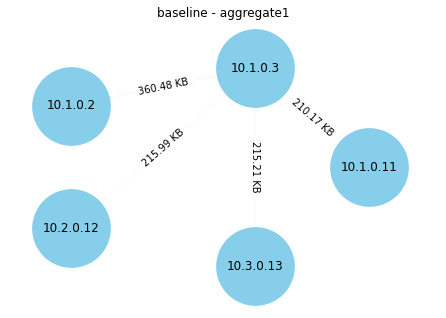

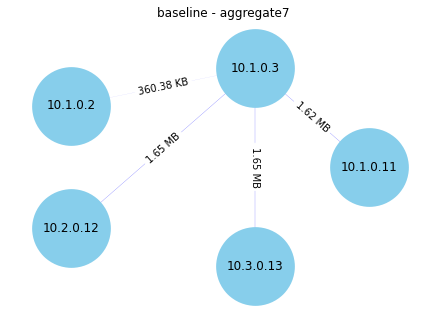

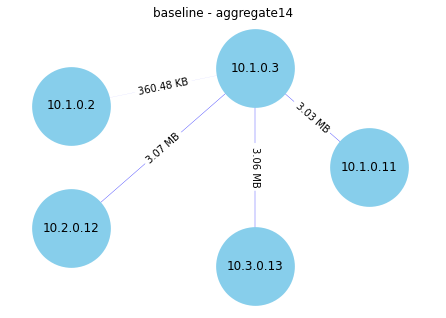

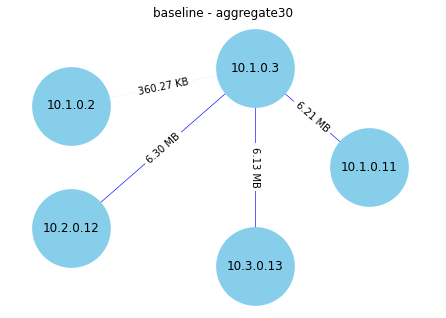

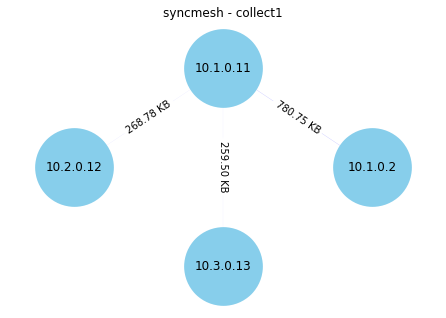

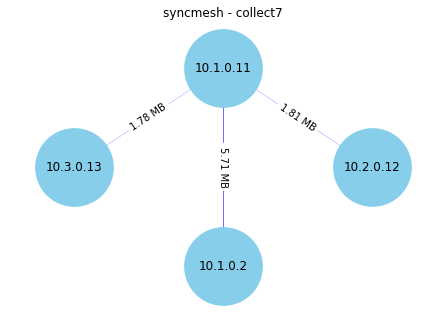

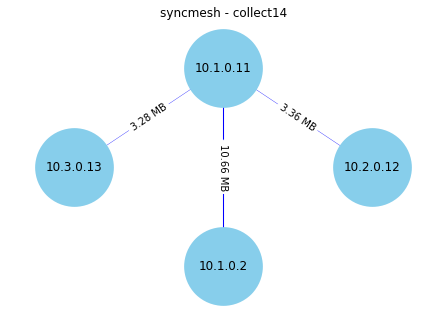

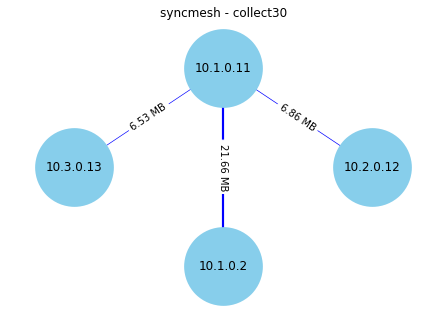

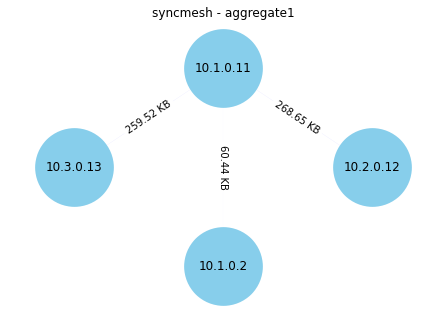

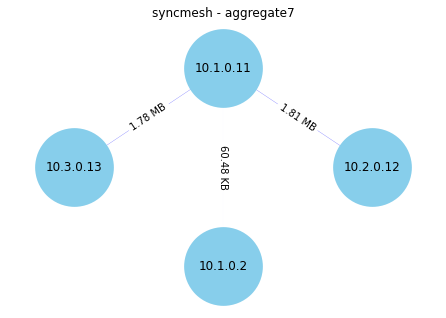

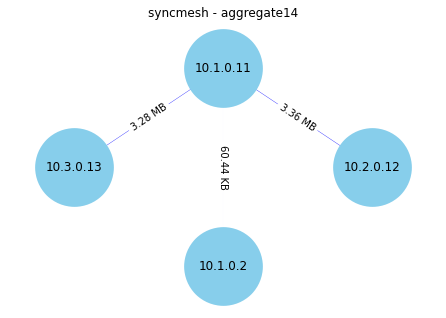

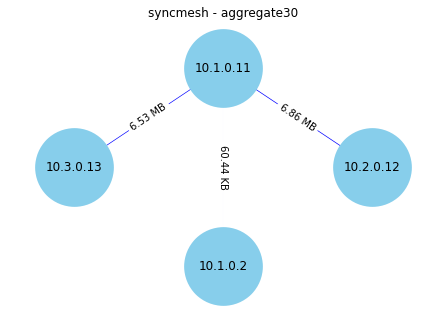

In [65]:
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        G = nx.Graph()
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            # print(node_dataset_key) 
            if len(subset["ip.dst"]) > 0:
                G.add_edge(subset["ip.src"].iloc[0], subset["ip.dst"].iloc[0], color='b', weight=subset["ip.len"].sum()/10000000, label=to_human_readable(subset["ip.len"].sum()))

        pos = nx.circular_layout(G)

        plt.figure(int(str(index)+str(e_index)))
        edges = G.edges()
        colors = [G[u][v]['color'] for u,v in edges]
        weights = [G[u][v]['weight'] for u,v in edges]
        edgelabels = dict([((u, v), G[u][v]['label']) for u,v in edges])
        nx.draw(G, pos, edge_color=colors, width=weights, with_labels = True, node_size=1500, node_color="skyblue", node_shape="o", alpha=1, linewidths=40)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edgelabels)

        plt.axis('off')
        axis = plt.gca()
        axis.set_title(subset_key + " - " + experiment_key)
        axis.set_xlim([1.2*x for x in axis.get_xlim()])
        axis.set_ylim([1.2*y for y in axis.get_ylim()])
        fig.savefig("out/network_"+subset_key+"-"+experiment_key+".png")

node_experiment_datasets
# plt.show()

C:\Users\danie\AppData\Local\Temp/ipykernel_7016/3467378951.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


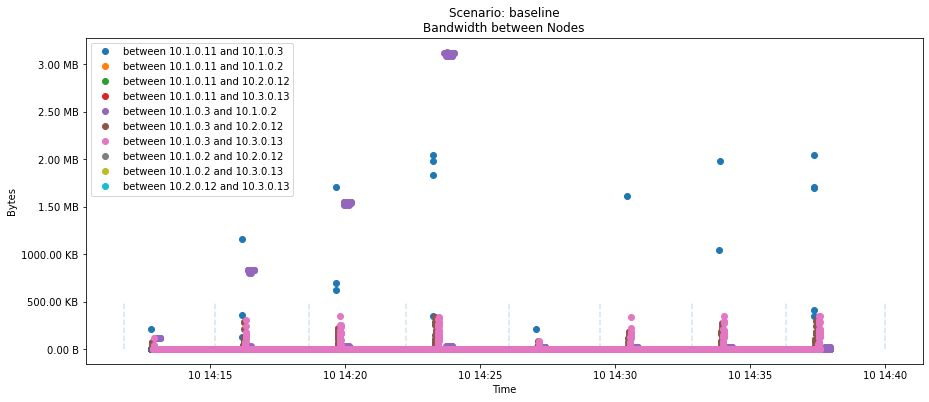

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# ax.set_ylim(0,500)
dataset="baseline"
for key in node_datasets[dataset]: 
    test = node_datasets[dataset][key].resample('100ms').agg({"ip.len":'sum'})
    ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
# for key in fromClientDataset: 
#     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
#     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
# set title and legend

for timing in list(pd.to_datetime(datasets[dataset][1])): 
    ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
ax.set_title('Scenario: '+dataset+'\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left')

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

C:\Users\danie\AppData\Local\Temp/ipykernel_7016/4238307838.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


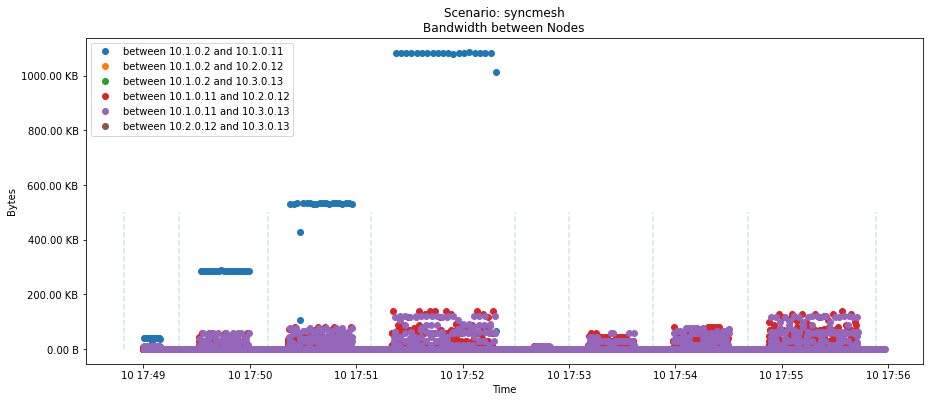

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# ax.set_ylim(0,500)
dataset="syncmesh"
for key in node_datasets[dataset]: 
    test = node_datasets[dataset][key].resample('100ms').agg({"ip.len":'sum'})
    ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
# for key in fromClientDataset: 
#     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
#     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
# set title and legend

for timing in list(pd.to_datetime(datasets[dataset][1])): 
    ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
ax.set_title('Scenario: '+dataset+'\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left')

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

In [68]:
print(to_human_readable(df_baseline["len"].sum()))
print(to_human_readable(df_base["ip.len"].sum()))
print("collect 1 - day", to_human_readable(df_baseline.loc[str('2021-08-28T01:32:20.769974404'):str('2021-08-28T14:24:25.769974404')]["len"].sum()))
print("collect 30 - day", to_human_readable(df_base.loc[str('2021-09-10T11:13:48.949304'):str('2021-09-10T11:15:25.477353')]["ip.len"].sum()))

NameError: name 'df_baseline' is not defined

C:\Users\danie\AppData\Local\Temp/ipykernel_11140/1000137497.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


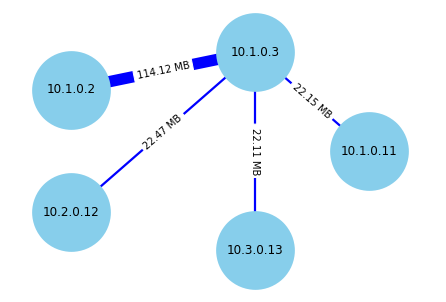